In [1]:
# NumPy library: allows for numerical computing
import numpy as np

# pandas library: used for data manipulation and analysis
import pandas as pd

# matplotlib library: plots everything
import matplotlib.pyplot as plt
%matplotlib inline

_________

# Case II

__Best Asset Management (BAM) is a top-notch asset management company with operations worldwide. Your team got an internship opportunity and your first assignment is to help in the advisory process for a wealthy investor, Mr. Gonzalez.__

__
Mr. Gonzalez approached BAM for the development of an investment strategy more adjusted to his risk-return profile. Your internship supervisor, Mrs. Crusoe, wants you to conduct a comprehensive analysis on what might be a good asset allocation for this investor.__

In [2]:
# Import the excel file
data = pd.read_excel('./data_case.xlsx', index_col='Date')

# Order the columns in alphabetical order
data = data.reindex(sorted(data.columns), axis=1).drop(pd.Timestamp('2004-12-31'))

# Show the data
data.head()

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Date,,,,,
2005-01-07,0.061548,0.014354,0.019900,0.028100,-0.007989
2005-01-14,0.037780,-0.003776,0.003577,-0.003210,-0.007760
2005-01-21,0.007729,-0.007996,0.001278,0.001171,0.009977
2005-01-28,-0.013148,0.006571,0.002871,0.001559,-0.018529
2005-02-04,-0.009279,0.033628,0.012232,0.017711,0.032902


__ For your assignment Mrs. Crusoe gave you weekly data on several asset classes that she considers appropriate for the investor and raised some questions that she believes will strengthen your analysis.__

__The risk-free rate is 3%.__

In [3]:
# Define the risk-free variable
r_f = 0.03

__________________

## Question 1

__ How did each of the asset classes performed throughout the whole sample period?__

In [4]:
# Create table, DataFrame, with historical indicators
sample_indicators = pd.DataFrame({'mean': data.mean()*(365.25/7), 
                                  'std': data.std() * np.sqrt(365.25/7),
                                  'min': data.min(),
                                  'max': data.max()})

# Show table
sample_indicators

,max,mean,min,std
Commodities,0.143364,0.057562,-0.182563,0.215036
Equity,0.109478,0.094019,-0.179928,0.163920
Fixed income,0.059763,0.044750,-0.033792,0.070888
Hedge Funds,0.042825,0.023183,-0.051908,0.098036
Real Estate,0.174583,0.087123,-0.143572,0.208388


In [5]:
# Get covariance variance matrix
S = data.cov()*(365.25/7)

# Show it
S

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Commodities,0.046241,0.014588,-0.000341,0.005410,0.012579
Equity,0.014588,0.026870,0.000484,0.008068,0.027308
Fixed income,-0.000341,0.000484,0.005025,0.004740,0.000799
Hedge Funds,0.005410,0.008068,0.004740,0.009611,0.006834
Real Estate,0.012579,0.027308,0.000799,0.006834,0.043426


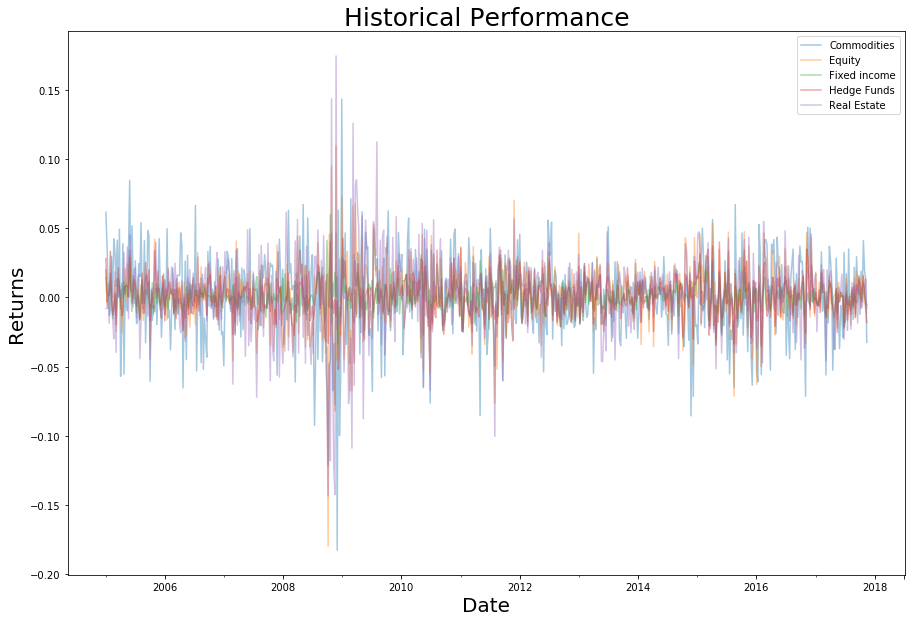

In [6]:
# Visualize the returns
data.plot(alpha=.4, figsize = (15,10), title='Data')

## Define the labels
plt.title('Historical Performance', fontsize=25)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Returns', fontsize=20)
plt.rc('font', size=16);

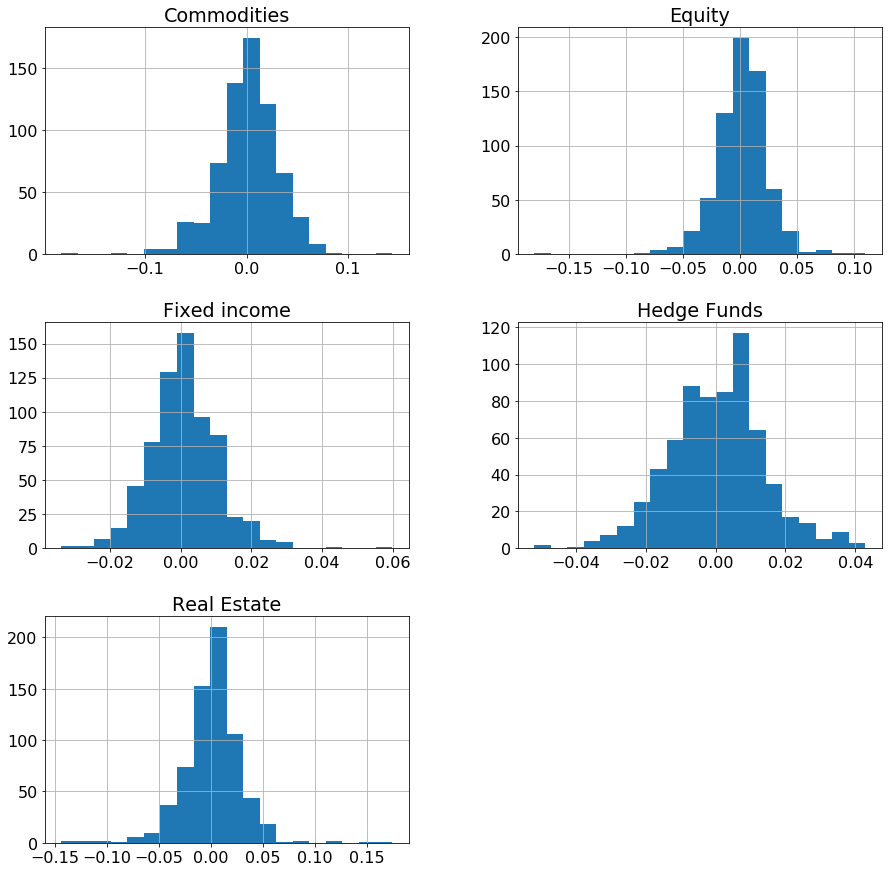

In [7]:
# Plot a histogram using 20 bins of the 5 asset classes
pd.DataFrame.hist(data, bins=20, figsize = (15,15), xlabelsize=16);

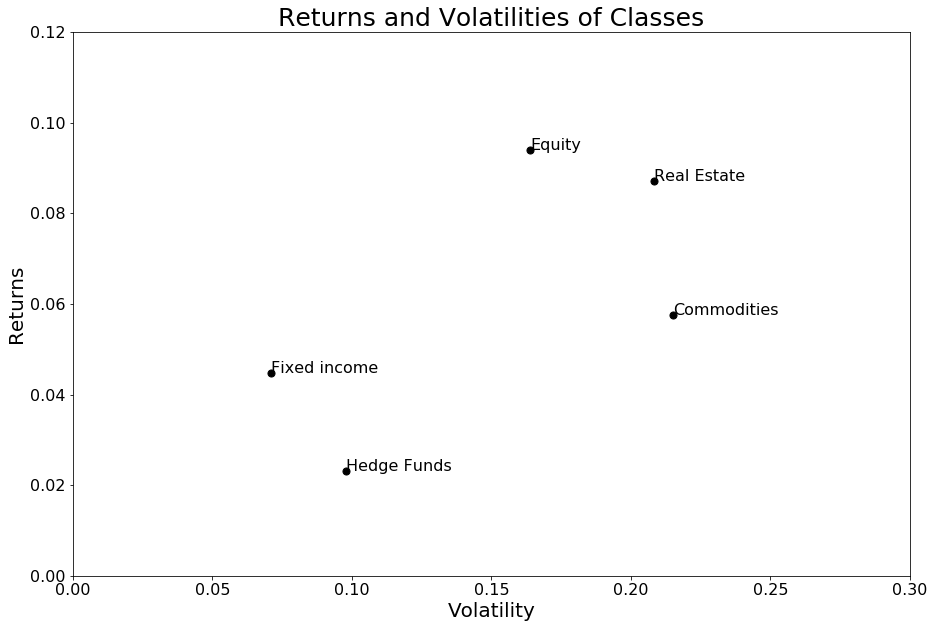

In [8]:
# Plot the Returns Volatility scatter
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(sample_indicators['std'], sample_indicators['mean'], marker="o",color='xkcd:black',s=50)

# Add the labels to each class
for i, txt in enumerate(data.columns.tolist()):
    ax.annotate(txt, (sample_indicators['std'].tolist()[i],sample_indicators['mean'].tolist()[i]))

# Define the limits for the graph
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

# Define the labels
plt.title('Returns and Volatilities of Classes', fontsize=25)
plt.xlabel('Volatility', fontsize=20)
plt.ylabel('Returns', fontsize=20);

plt.rc('font', size=16);

___________

## Question 2

__ If there are no restrictions on short sales what would be the tangency portfolio? And if the investor is restricted on short sales? Compare the two portfolios.__

Firstly, with no restriction:

$$ weights_{T_{nr}} = \frac{S^{-1}\{E(r)-r_f\}}{Sum\left[S^{-1}\{E(r)-r_f\}\right]} $$

In [9]:
# Get weights of tangent portfolio with no restrictions:
w_T_nr = np.dot(np.linalg.inv(S), sample_indicators['mean'] - r_f)/sum(np.dot(np.linalg.inv(S), sample_indicators['mean']- r_f))

# Display weights
print(w_T_nr)

[ 0.03964144  1.00047184  1.93136873 -1.72722291 -0.24425909]


In [10]:
# Get expected return of the tangency portfolio
E_r_T_nr = np.dot(w_T_nr, sample_indicators['mean'])

# Get standard deviation of the tangency portfolio
std_T_nr = np.sqrt(np.dot(np.transpose(w_T_nr), np.dot(S, w_T_nr)))

# Print E(r) and std
print('E(r):', E_r_T_nr)
print('σ:', std_T_nr)

E(r): 0.121451164838
σ: 0.105497771132


<br>

Secondly, with restrictions:

In [11]:
# Set Monte Carlo approach with 1M portfolios
num_portfolios = 5000000

# List of stocks in portfolio
stocks = data.columns.tolist()

# Set up table to hold results
results = np.zeros((4+len(stocks)-1,num_portfolios))

# Loop through all the portfolios
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(5))
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(sample_indicators['mean'] * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(S, weights)))
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    #store Sharpe Ratio
    results[2,i] = (results[0,i]-r_f) / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

# Convert the table
results_table_r = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_table_r.head()

,ret,stdev,sharpe,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
0,0.045934,0.080098,0.198926,0.017413,0.156455,0.375173,0.404388,0.046571
1,0.054722,0.101138,0.244437,0.231539,0.165655,0.196919,0.287067,0.118821
2,0.072914,0.141207,0.303912,0.304887,0.273430,0.060341,0.070767,0.290574
3,0.057785,0.107125,0.259374,0.180649,0.236657,0.124096,0.318601,0.139997
4,0.071060,0.121550,0.337803,0.207547,0.283531,0.210391,0.046426,0.252105


In [12]:
# Locate position of portfolio with highest Sharpe Ratio
max_sharpe_r = results_table_r.iloc[results_table_r['sharpe'].idxmax()]

# Locate positon of portfolio with minimum standard deviation
min_vol_r = results_table_r.iloc[results_table_r['stdev'].idxmin()]

# Get weights of tangent portfolio with no restrictions:
w_T_r = np.transpose(max_sharpe_r[3:].tolist())

# Display weights
print(w_T_r)

[ 0.02887327  0.46871935  0.49487116  0.0011734   0.00636282]


In [13]:
# Get expected return of the tangency portfolio
E_r_T_r = np.dot(w_T_r, sample_indicators['mean'])

# Get standard deviation of the tangency portfolio
std_T_r = np.sqrt(np.dot(np.transpose(w_T_r), np.dot(S, w_T_r)))

# Print E(r) and std
print('E(r):', E_r_T_r)
print('σ:', std_T_r)

E(r): 0.0684577873471
σ: 0.089283153148


<br>

Comparing both restricted and not restricted:

In [14]:
# Create table to show results
question_2 = pd.DataFrame({'T_nr': [E_r_T_nr, std_T_nr], 
                           'T_r': [E_r_T_r, std_T_r]}, index=['E(r)', 'σ'])
question_2

,T_nr,T_r
E(r),0.121451,0.068458
σ,0.105498,0.089283


_______

## Question 3

__  Assuming an investor with a quadratic function 𝑈𝑥 = 𝐸(𝑟) − 𝛾/2 × 𝜎^2 and a risk aversion level (𝛾) of 6, what would be the optimal portfolio if Mr. Gonzalez has no restrictions on short sales? How does your answer change if he has restrictions on short sales? Compare the two recommendations and analyze how they behave for different levels of risk aversion.__

In [15]:
# Define gamma
gamma = 6.0

In [16]:
# Define function that outputs E(r) and std for a given aversion level
def Optimal_ret_and_std_per_gamma(E_r_T, std_T, gamma_value):
    # Calculate the weight of T on the optimal portfolio
    w_T = (E_r_T-r_f)/(gamma_value*(std_T**2))
    
    # Get expected return of the optimal portfolio
    E_r_o = w_T*E_r_T + (1-w_T)*r_f
    
    # Get standard deviation of the optimal portfolio
    std_o = w_T*std_T
    
    # Indicate the otputs of the function
    return(w_T, E_r_o, std_o)

Weight of the tangency porfolio on the optimal portfolio: 
$$ w_T = \frac{r_T-r_f}{\gamma \sigma_T^2} $$

<br>

Firstly, with no restrictions:

In [39]:
# Run the function with the E(r), std, and gamma specific to no restrictions
w_T_nr, E_r_o_nr , std_o_nr = Optimal_ret_and_std_per_gamma(E_r_T_nr, std_T_nr, gamma)

# Add the results to the compare_table
question_3 = question_2.copy()
question_3['o_nr_6'] = [E_r_o_nr, std_o_nr]

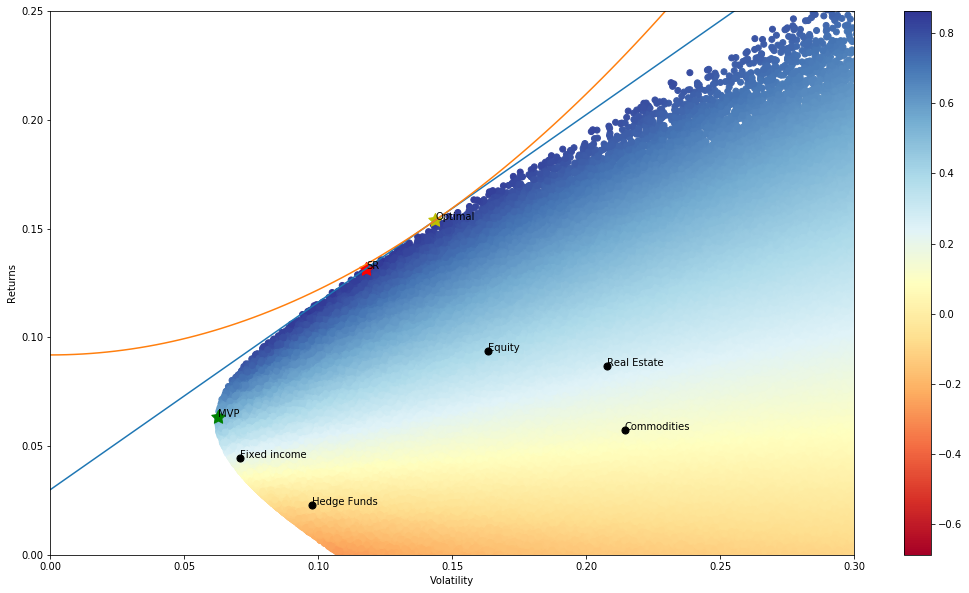

In [48]:
# Plot the portfolios so far with no restrictions.
# The code to plot the graph is too lenghty so we decided not to show it.

<br>

Secondly, with restrictions:

In [41]:
# Run the function with the E(r), std, and gamma specific to restrictions
w_T_r, E_r_o_r , std_o_r = Optimal_ret_and_std_per_gamma(E_r_T_r, std_T_r, gamma)

# Add the results to the compare_table
question_3['o_r_6'] = [E_r_o_r, std_o_r]

In [22]:
def graph_formulas(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)

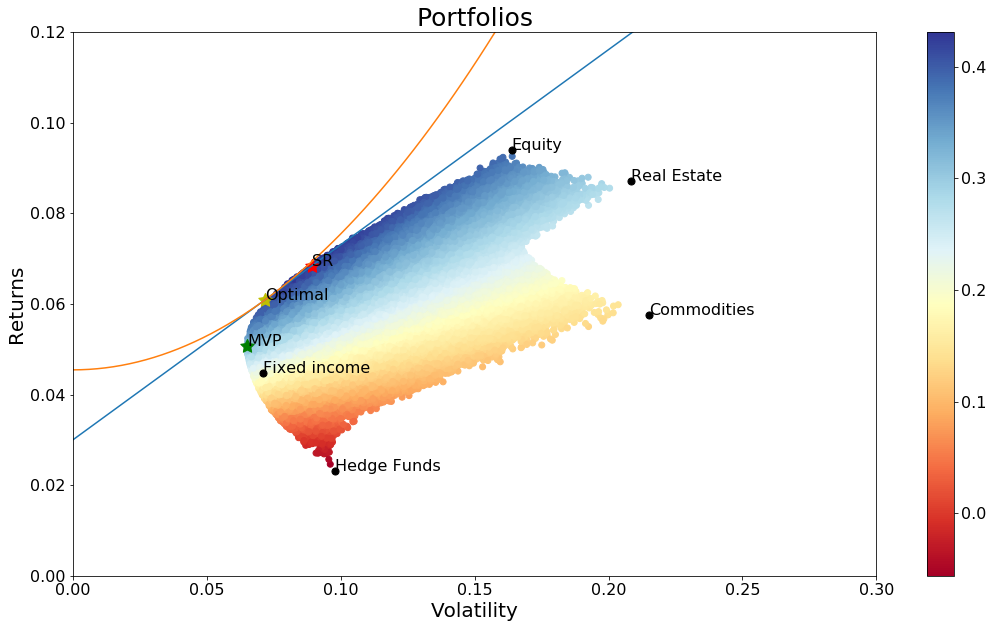

In [20]:
# Set configuration of the graph
plt.figure(figsize=(18, 10))
plt.xlabel('Volatility', fontsize=20)
plt.ylabel('Returns', fontsize=20)
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

## Define the labels
plt.title('Portfolios', fontsize=25)

plt.rc('font', size=16) 


# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_table_r.stdev,results_table_r.ret,c=results_table_r.sharpe,cmap='RdYlBu')    
plt.colorbar()

# Add classes
plt.scatter(sample_indicators['std'], sample_indicators['mean'], marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data.columns.tolist()):
    plt.annotate(txt, (sample_indicators['std'].tolist()[i],sample_indicators['mean'].tolist()[i]))

# Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_r[1],min_vol_r[0],marker=(5,1,0),color='g',s=200)
plt.annotate('MVP', (min_vol_r[1],min_vol_r[0]))    
    
# Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_r[1],max_sharpe_r[0],marker=(5,1,0),color='r',s=200)
plt.annotate('SR', (max_sharpe_r[1],max_sharpe_r[0]))
             
# Add CML line
graph_formulas(lambda x: (r_f + (max_sharpe_r[0]-r_f)*(x/max_sharpe_r[1])), np.linspace(0.0,0.3, 100))

# Add optimal portfolio 
plt.scatter(std_o_r,E_r_o_r,marker=(5,1,0),color='y',s=200)
plt.annotate('Optimal', (std_o_r,E_r_o_r))

# Add investors utility curve
graph_formulas(lambda x: ((E_r_o_r - gamma*(std_o_r**2)/2)+gamma*(x**2)/2), np.linspace(0.0,0.3, 100))

plt.show();

<br>

Comparing both restricted and not restricted:

In [42]:
question_3

,T_nr,T_r,o_nr_6,o_r_6
E(r),0.121451,0.068458,0.155239,0.060923
σ,0.105498,0.089283,0.144476,0.071790


<br>

Compare different levels of aversion:


In [43]:
# Define different gammas
different_gammas = [2, 4, 6, 8, 10]

In [44]:
# Create a loop that recalculates the returns and the std per value of gamma
for item in different_gammas:
    # Recalculate return and std for 'not restricted' and 'restricted'
    w_T_nr_item, E_r_o_nr_item , std_o_nr_item = Optimal_ret_and_std_per_gamma(E_r_T_nr, std_T_nr, item)
    w_T_r_item, E_r_o_r_item , std_o_r_item = Optimal_ret_and_std_per_gamma(E_r_T_r, std_T_r, item)    
    
    # Add the new value to the comparison table
    question_3['o_nr_'+str(item)] = [E_r_o_nr_item, std_o_nr_item]
    question_3['o_r_'+str(item)] = [E_r_o_r_item, std_o_r_item]

In [45]:
# Show the comparison table with the new results varying with gamma
question_3

,T_nr,T_r,o_nr_6,o_r_6,o_nr_2,o_r_2,o_nr_4,o_r_4,o_nr_8,o_r_8,o_nr_10,o_r_10
E(r),0.121451,0.068458,0.155239,0.060923,0.405718,0.122768,0.217859,0.076384,0.123929,0.053192,0.105144,0.048554
σ,0.105498,0.089283,0.144476,0.071790,0.433427,0.215370,0.216713,0.107685,0.108357,0.053842,0.086685,0.043074


In [46]:
# Show the comparison table with the new results varying with gamma for not restricted
question_3_o_nr = question_3[['o_nr_2', 'o_nr_4', 'o_nr_6', 'o_nr_8', 'o_nr_10']]
question_3_o_nr

,o_nr_2,o_nr_4,o_nr_6,o_nr_8,o_nr_10
E(r),0.405718,0.217859,0.155239,0.123929,0.105144
σ,0.433427,0.216713,0.144476,0.108357,0.086685


In [47]:
# Show the comparison table with the new results varying with gamma for restricted
question_3_o_r = question_3[['o_r_2', 'o_r_4', 'o_r_6', 'o_r_8', 'o_r_10']]
question_3_o_r

,o_r_2,o_r_4,o_r_6,o_r_8,o_r_10
E(r),0.122768,0.076384,0.060923,0.053192,0.048554
σ,0.215370,0.107685,0.071790,0.053842,0.043074


In [52]:
question_3['T_nr'].iloc[1]

0.10549777113156303

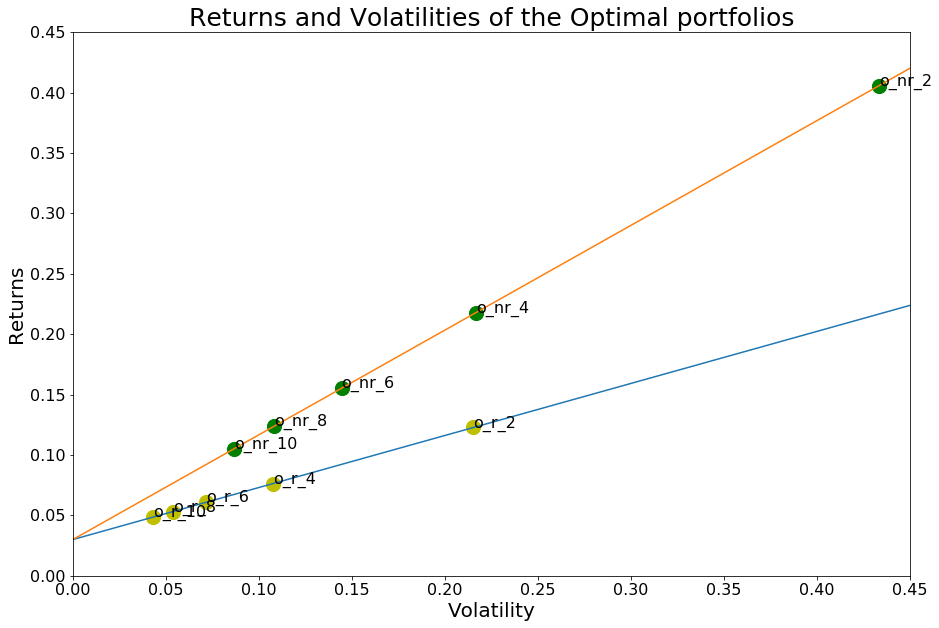

In [54]:
# Plot the optimal portfolios for both restricted and not restricted at different risk aversion levels.
# The code to plot the graph is too lenghty so we decided not to show it.

________

## Question 4

__  What is the impact on your prior recommendations if the expected return changes? Perform a sensitivity analysis and comment on the differences. __

In [ ]:
# Specify different expected return changes
better_returns = 1.20
worse_returns = 0.80

In [ ]:
# Update the expected returns with the two options
sample_indicators['mean_better'] = sample_indicators['mean']*better_returns
sample_indicators['mean_worse'] = sample_indicators['mean']*worse_returns

# Show the new table
sample_indicators

In [ ]:
# The soltions of this question aren't much fun to read so they are not displayed.
# This exercises makes you redo everything so far with different initial returns. 

________

## Question 5

__  Finally, Mrs. Crusoe asks you to suggest 3 stocks and to estimate expected returns and standard deviation (total, systematic and idiosyncratic) on each of them according to the CAPM. Would you recommend the investment in any of the 3 stocks? Explain. __

In [8]:
# Import the Bloomberg file
bbg_data = pd.read_excel('./data_bloomberg.xlsx', index_col='Dates').dropna(axis=1, how='any')

# Define stocks with no empty values
bbg_stocks = bbg_data[bbg_data.columns.tolist()[2:]]

In [9]:
# Show table with Bloomberg data
bbg_data.head()

,USGG3M Index,SPX Index,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,...,XEC UN Equity,XEL UN Equity,XL UN Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2004-12-31,2.2117,1211.9163,16.2379,29.120,4.6000,14.2349,22.3208,27.00,31.370,22.31,...,37.90,18.20,77.65,29.65,51.26,28.100,44.8144,16.9625,80.12,68.03
2005-01-07,2.3142,1186.7127,15.3013,28.700,4.9464,14.0456,22.7275,26.61,29.390,21.84,...,34.80,17.42,76.09,27.33,49.79,27.190,42.7594,16.6641,79.50,64.99
2005-01-14,2.3551,1185.2720,14.8566,28.973,5.0143,13.8928,22.2538,26.29,29.115,21.91,...,36.93,17.95,77.06,26.54,51.07,27.675,42.5750,16.2794,78.77,63.56
2005-01-21,2.3450,1168.7344,14.6882,28.547,5.0379,13.8297,22.1239,25.16,28.535,22.66,...,39.33,18.04,75.20,27.35,50.44,27.650,41.4685,16.4019,80.50,65.74
2005-01-28,2.4475,1172.4645,14.5602,28.367,5.2843,14.1597,21.7823,25.60,27.740,23.06,...,35.75,18.06,73.72,28.77,51.27,28.450,40.5991,16.2578,79.89,66.25


In [10]:
# Find returns of all stocks
bbg_ri = bbg_stocks.pct_change().drop(pd.Timestamp('2004-12-31'))

In [11]:
# Calculate returns of the SPX and drop the first entry
bbg_rM = bbg_data['SPX Index'].pct_change().drop(pd.Timestamp('2004-12-31'))

In [12]:
# Calculate returns of the risk free proxy and drop the first entry
bbg_r_f = ((1+(bbg_data['USGG3M Index'].drop(pd.Timestamp('2004-12-31'))/100))**(3/12)-1)/(3*4.34812141)

In [13]:
bbg_r_f.mean()

0.00022567480368285178

In [14]:
# Create empty table with betas, alphas, risks, and SML returns
bbg_betas = pd.DataFrame(index=['E_r', 'β', 'alpha', 'risk_t', 'risk_s', 'risk_i', 'E_r_SML'])

# Create a loop that evaluates all stocks individually  
for tick in bbg_stocks.columns:
    # Calculate expected returns per stock
    expected_return = bbg_ri[tick].mean()*(365.25/7)
    
    # Get beta - the slope - and alpha - the intercept - for each stock
    slope, intercept = np.polyfit(bbg_rM-bbg_r_f, bbg_ri[tick] - bbg_r_f , 1)
    
    # Calculate total risk
    risk_t = bbg_ri[tick].var()*(365.25/7)
    
    # Calculate systemic risk
    risk_s = (slope**2)*(bbg_rM.var()*(365.25/7))
    
    #  Calculate idiosyncratic risk
    risk_i = risk_t - risk_s
    
    # Calculate SML expected return
    SML = bbg_r_f.mean()*(365.25/7) + slope*(bbg_rM.mean()*(365.25/7)-bbg_r_f.mean()*(365.25/7))
    
    # Add all calculated variables to the table created above
    bbg_betas[tick] = [expected_return, slope, intercept, risk_t, risk_s, risk_i, SML]

In [16]:
# Display table 
bbg_betas

,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,ADS UN Equity,ADSK UW Equity,...,XEC UN Equity,XEL UN Equity,XL UN Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity
E_r,0.162009,0.139476,0.345785,0.168194,0.116036,0.179135,0.182356,0.109505,0.182580,0.170503,...,0.168508,0.132618,0.133810,0.131126,0.082191,0.100893,0.037850,0.165710,0.065571,0.107790
β,1.266963,0.807226,1.056657,0.642428,0.559924,0.893509,1.094241,0.900635,1.281726,1.442143,...,1.434173,0.473835,1.843758,0.974247,0.818754,0.909687,1.429501,0.831739,0.864272,1.826617
alpha,0.000880,0.001173,0.004734,0.001984,0.001115,0.001797,0.001542,0.000452,0.001251,0.000766,...,0.000740,0.001568,-0.000571,0.000750,0.000057,0.000272,-0.001756,0.001638,-0.000333,-0.001043
risk_t,0.089982,0.095706,0.111515,0.047279,0.037109,0.059363,0.090584,0.088483,0.122380,0.151343,...,0.151262,0.023734,0.307645,0.079527,0.042222,0.054341,0.111783,0.055402,0.070750,0.276877
risk_s,0.045998,0.018673,0.031995,0.011827,0.008984,0.022878,0.034311,0.023244,0.047076,0.059598,...,0.058941,0.006434,0.097414,0.027199,0.019210,0.023714,0.058557,0.019824,0.021405,0.095611
risk_i,0.043984,0.077034,0.079520,0.035452,0.028125,0.036485,0.056273,0.065239,0.075304,0.091745,...,0.092321,0.017301,0.210231,0.052328,0.023012,0.030628,0.053226,0.035579,0.049345,0.181266
E_r_SML,0.116103,0.078246,0.098785,0.064676,0.057882,0.085351,0.101880,0.085938,0.117319,0.130528,...,0.129872,0.050793,0.163599,0.091999,0.079195,0.086683,0.129487,0.080264,0.082943,0.162187


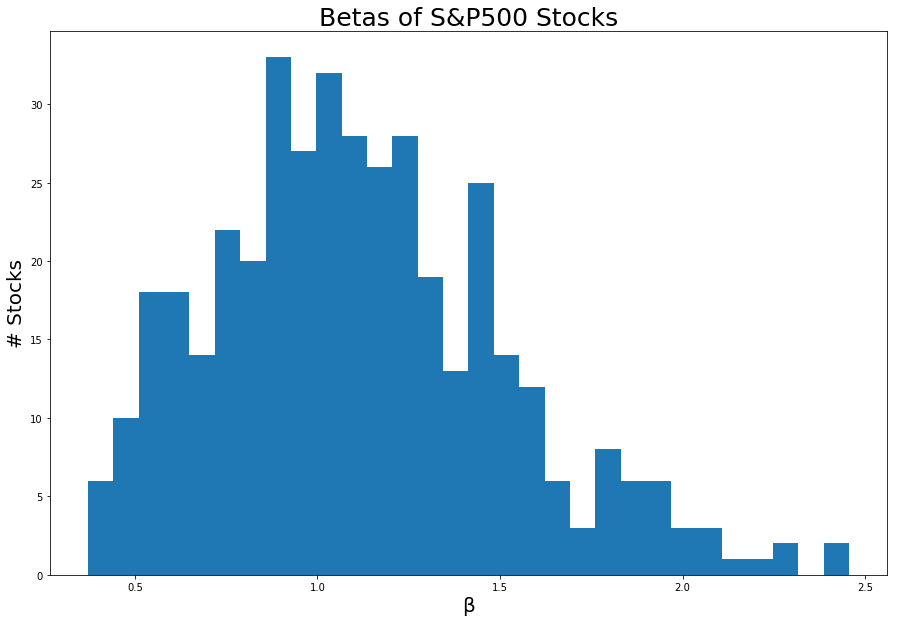

In [11]:
# Ploting a histogram with the calculated betas

plt.subplots(figsize = (15,10))
plt.hist(bbg_betas.iloc[1].transpose().values.tolist(), bins=30)

plt.rc('font', size=16) 
plt.title('Betas of S&P500 Stocks', fontsize=25)
plt.xlabel('β', fontsize=20)
plt.ylabel('# Stocks', fontsize=20);

In [17]:
# Picking 3 stocks: lowest beta, biggest beta, and biggest return/highest alpha
picks = ['SO UN Equity', 'LNC UN Equity', 'NFLX UW Equity'] 

In [ ]:
# Graph with historical returns per beta with all the observations
# The 2 stock picks are highlighted 

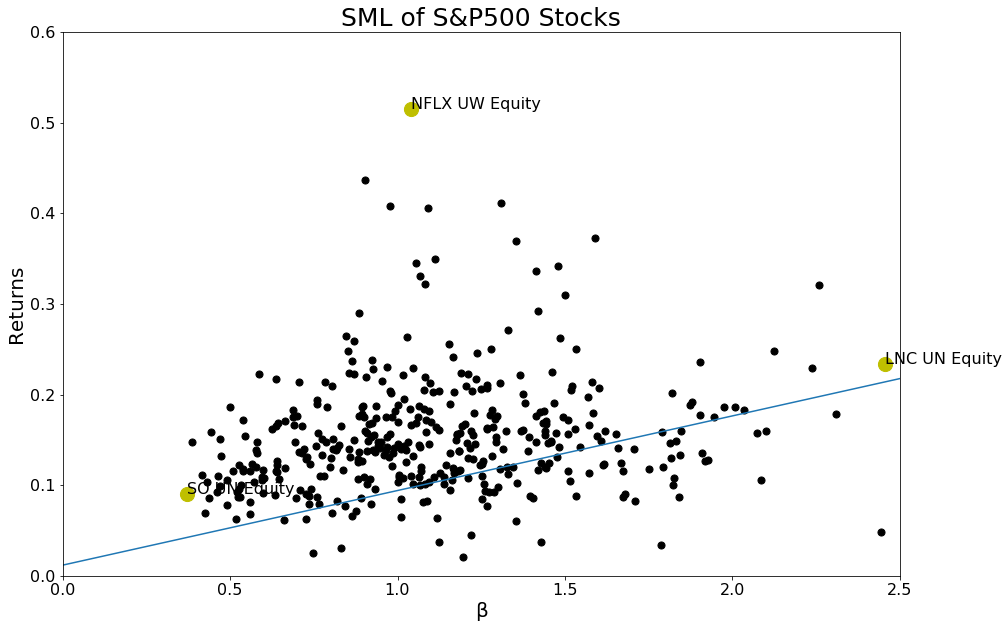

In [47]:
plt.subplots(figsize = (15,10))
plt.scatter(bbg_betas.iloc[[1]].transpose().values, bbg_betas.iloc[[0]].transpose().values, marker="o",color='xkcd:black',s=50)

## Define the limits for the graph
plt.ylim((0.00,0.6))
plt.xlim((0.00,2.5))

## Define the labels
plt.title('SML of S&P500 Stocks', fontsize=25)
plt.xlabel('β', fontsize=20)
plt.ylabel('Returns', fontsize=20)
plt.rc('font', size=16) 

for i in picks:
    plt.scatter(bbg_betas[i][1],bbg_betas[i][0],marker='o',color='y',s=200)
    plt.annotate(i, (bbg_betas[i][1],bbg_betas[i][0]))


## Add SML line
graph_formulas(lambda x: (bbg_r_f.mean()*(365.25/7) + x*(bbg_rM.mean()*(365.25/7)-bbg_r_f.mean()*(365.25/7))), np.linspace(0.0,2.5, 100));

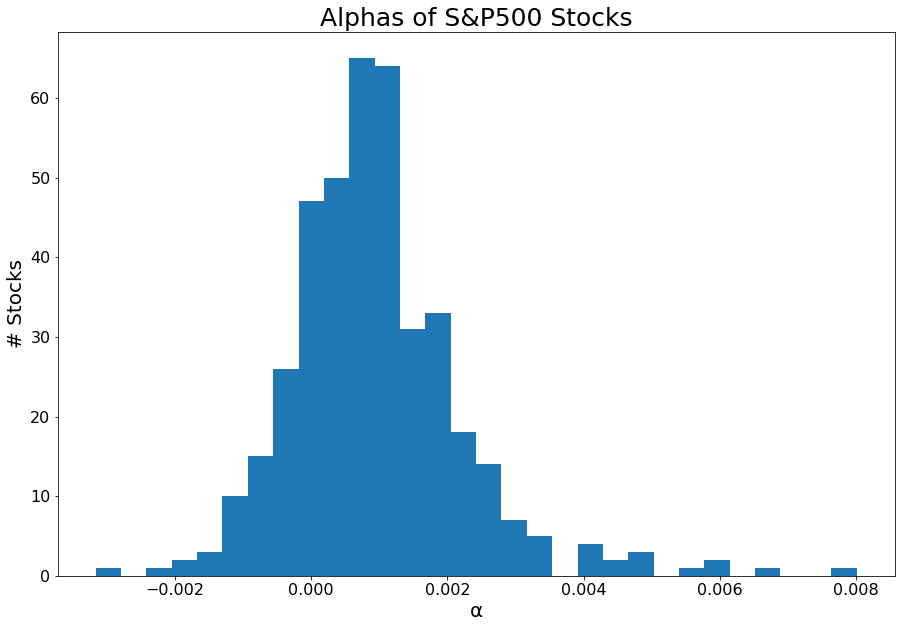

In [48]:
# Ploting a histogram with the calculated alphas
# Same code as above


plt.subplots(figsize = (15,10))
plt.hist(bbg_betas.iloc[2].transpose().values.tolist(), bins=30)

plt.rc('font', size=16) 
plt.title('Alphas of S&P500 Stocks', fontsize=25)
plt.xlabel('α', fontsize=20)
plt.ylabel('# Stocks', fontsize=20);

In [49]:
bbg_betas.transpose().idxmax()

E_r        NFLX UW Equity
β           LNC UN Equity
alpha      NFLX UW Equity
risk_t      AIG UN Equity
risk_s      LNC UN Equity
risk_i      AIG UN Equity
E_r_SML     LNC UN Equity
dtype: object

In [50]:
bbg_betas.transpose().idxmin()

E_r         GE UN Equity
β           SO UN Equity
alpha        C UN Equity
risk_t     JNJ UN Equity
risk_s      SO UN Equity
risk_i     JNJ UN Equity
E_r_SML     SO UN Equity
dtype: object

In [18]:
def sml_maker(stock):
    plt.subplots(figsize = (15,10))

    ## Add SML line
    graph_formulas(lambda x: (bbg_r_f.mean()*(365.25/7) + x*(bbg_rM.mean()*(365.25/7)-bbg_r_f.mean()*(365.25/7))), np.linspace(0.0,2.5, 100))
    
    plt.scatter(bbg_betas[stock][1],bbg_betas[stock][0],marker='o',color='g',s=200)
    
    plt.scatter(bbg_betas[stock][1],bbg_betas[stock][-1],marker='o',color='y',s=200)
    
    
    plt.ylim((0,0.6))
    plt.xlim((0,2.5))
    
    ## Define the labels
    plt.title('SML of '+stock, fontsize=25)
    plt.xlabel('β', fontsize=20)
    plt.ylabel('Returns', fontsize=20)
    plt.rc('font', size=16);

In [19]:
def observations_maker(stock):
    plt.subplots(figsize = (15,10))
    plt.title('Observations of '+stock, fontsize=25)
    plt.axvline(x=0,linewidth=2, color = 'xkcd:black')    
    plt.axhline(y=0,linewidth=2, color = 'xkcd:black') 
    plt.xlabel('Market Returns', fontsize=20)
    plt.ylabel(stock+' Returns', fontsize=20)
    plt.rc('font', size=16);   
    plt.scatter(bbg_rM,bbg_ri[stock], s=5)
    graph_formulas(lambda x: (bbg_betas[i][1]*x+bbg_betas[i][2]), np.linspace(-.2,.2, 100))
    plt.ylim((-.15,.15))
    plt.xlim((-.2,.2));

First Pick: SO

In [73]:
# First Pick
i = picks[0]
bbg_betas[i]

E_r        0.090814
β          0.371582
alpha      0.000928
risk_t     0.022213
risk_s     0.003957
risk_i     0.018256
E_r_SML    0.042373
Name: SO UN Equity, dtype: float64

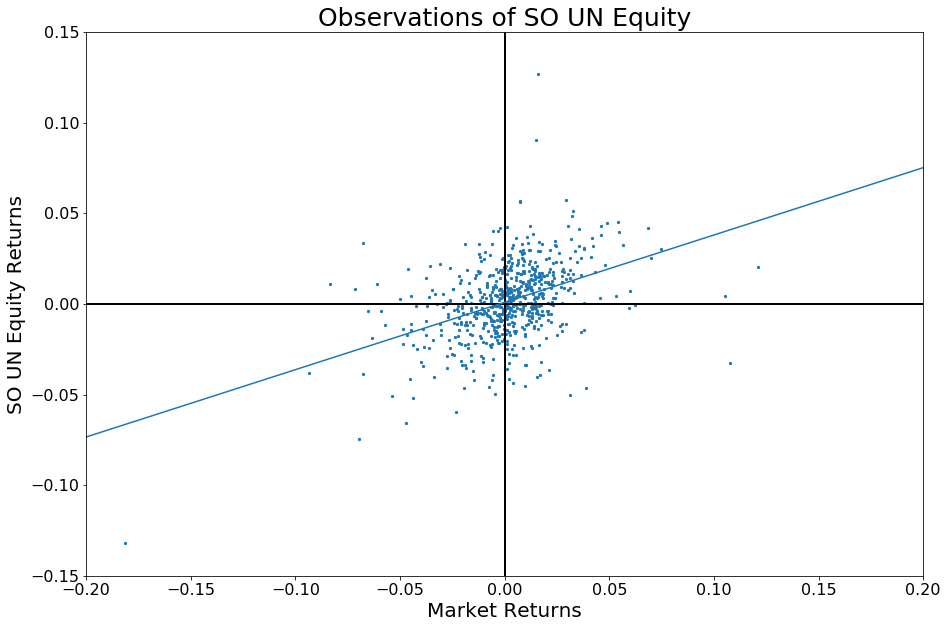

In [74]:
observations_maker(i)

In [75]:
bbg_ri['SO UN Equity'].max()

0.12675036361312775

In [76]:
bbg_rM.max()

0.12090575648419732

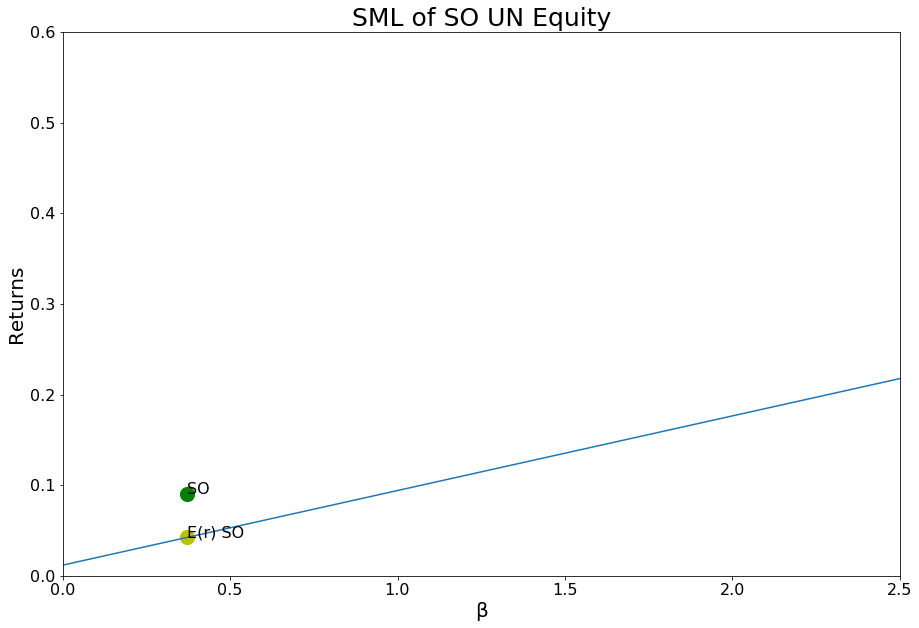

In [77]:
sml_maker(i)
plt.annotate('SO', (bbg_betas[i][1],bbg_betas[i][0]))
plt.annotate('E(r) SO', (bbg_betas[i][1],bbg_betas[i][-1]));

Second Pick: LNC

In [20]:
# Second Pick
i = picks[1]
bbg_betas[i]

E_r        0.234123
β          2.455485
alpha      0.000386
risk_t     0.399633
risk_s     0.172777
risk_i     0.226855
E_r_SML    0.213971
Name: LNC UN Equity, dtype: float64

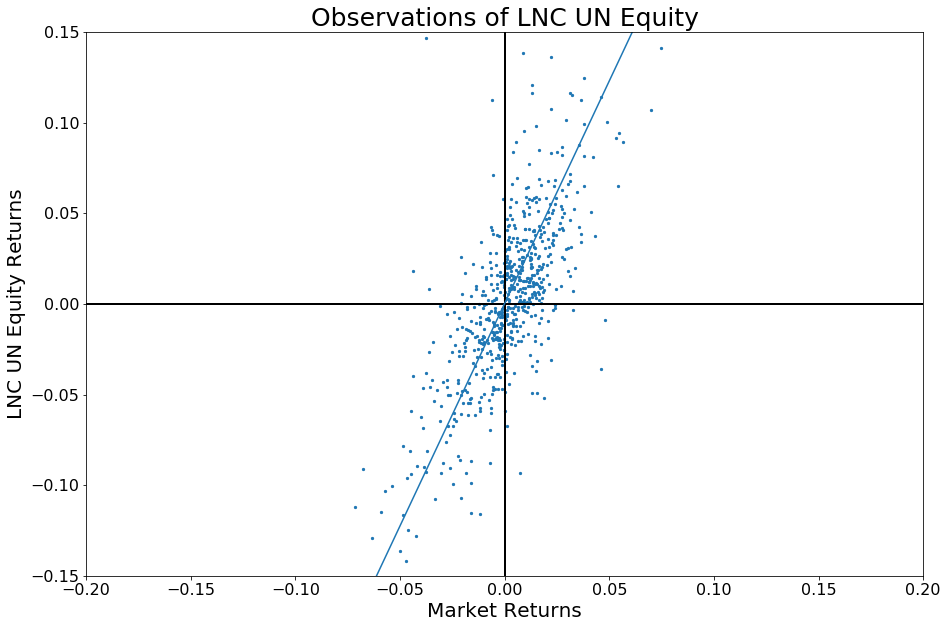

In [23]:
# Plot observations with a function defined but not shown
observations_maker(i)

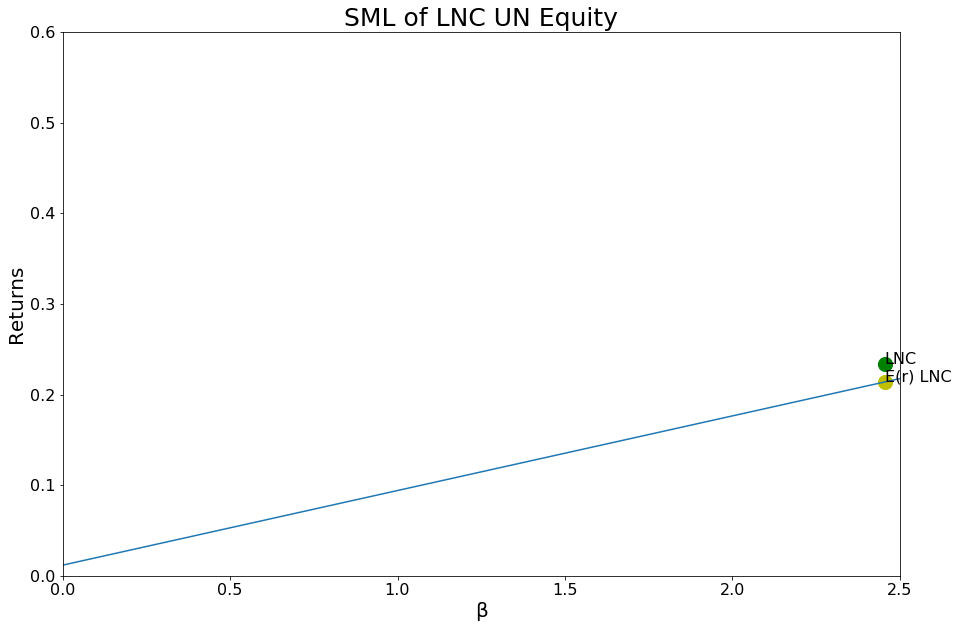

In [24]:
# Display SML graph with function defined but not shown
sml_maker(i)
plt.annotate('LNC', (bbg_betas[i][1],bbg_betas[i][0]))
plt.annotate('E(r) LNC', (bbg_betas[i][1],bbg_betas[i][-1]));

Third Pick: SO

In [44]:
# Third Pick
i = picks[2]
bbg_betas['NFLX UW Equity']

E_r        0.514999
β          1.039046
alpha      0.008005
risk_t     0.314230
risk_s     0.030937
risk_i     0.283293
E_r_SML    0.097335
Name: NFLX UW Equity, dtype: float64

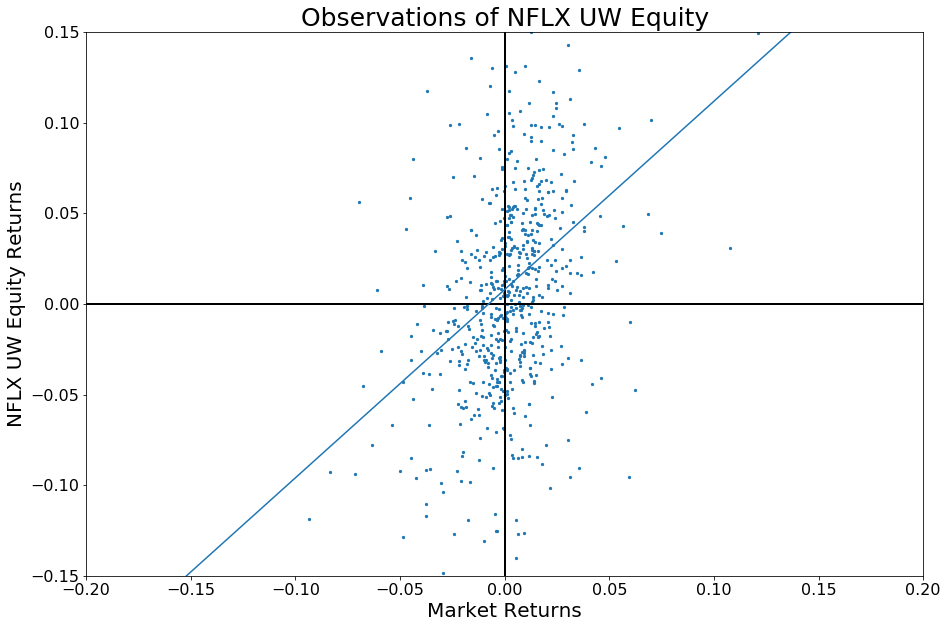

In [45]:
observations_maker(i)

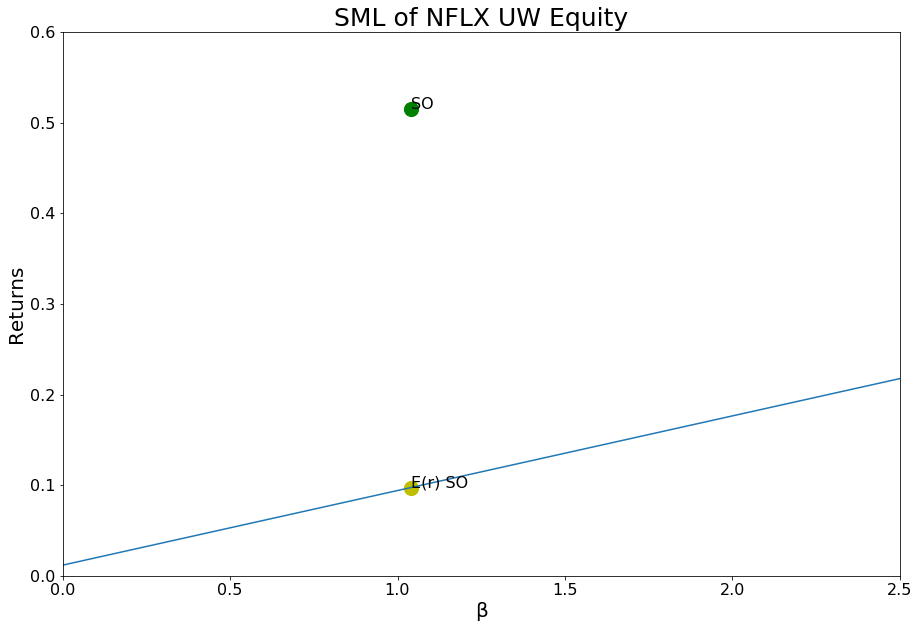

In [46]:
sml_maker(i)
plt.annotate('SO', (bbg_betas[i][1],bbg_betas[i][0]))
plt.annotate('E(r) SO', (bbg_betas[i][1],bbg_betas[i][-1]));